# BA 476 Team 10 Jupyter Notebook

In [1]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

## Setup

In [2]:
from pathlib import Path

import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm
from xgboost import XGBRegressor, XGBRFRegressor

In [3]:
# To collect results from all models as we go
full_results = pd.DataFrame()

# Color palette
sns.set(
    rc={
        "axes.facecolor": (1, 1, 1, 0),
        "figure.facecolor": (1, 1, 1, 0),
        "text.color": "lightgray",
        "xtick.color": "lightgray",
        "ytick.color": "lightgray",
    }
)
spotify_palette = sns.diverging_palette(279, 141, s=92, l=68, center="light", as_cmap=True)
spotify_colors = sns.diverging_palette(279, 141, s=92, l=68, center="light")

## Data Download and Processing
Download the supplementary data from Kaggle for artist info

In [4]:
if Path("data/spotify_artist_data.csv").exists():
    artist_stats = pd.read_csv("data/spotify_artist_data.csv")
else:
    path = kagglehub.dataset_download("adnananam/spotify-artist-stats")
    artist_stats = pd.read_csv(path + "/spotify_artist_data.csv", index_col=0)

    # Remove error rows b/c the creator didn't process correctly
    artist_stats = artist_stats[artist_stats["Lead Streams"] != "Lead Streams"]

    # Cast numeric columns to int
    for col in ["Lead Streams", "Feats", "Tracks", "One Billion", "100 Million"]:
        artist_stats[col] = artist_stats[col].str.replace(",", "").astype(int)

    # Remove the last updated column, it's not useful/relevant
    artist_stats = artist_stats.drop(columns=["Last Updated"])

    artist_stats.to_csv("data/spotify_artist_data.csv", index=False)

artist_stats.head()

,Artist Name,Lead Streams,Feats,Tracks,One Billion,100 Million
0,Drake,50162292808,19246513666,262,6,130
1,Bad Bunny,44369032140,5391990975,163,5,118
2,Ed Sheeran,38153682361,2791278201,240,10,62
3,The Weeknd,34767779741,4288903657,186,8,72
4,Taylor Swift,32596728109,424053296,323,1,96


Download the dataset from HuggingFace using Pandas, and drop the extra index column. The `na`/`NaN` values were dropped from the `artists` column because that column is used to merge the supplementary data above with the main dataset.

In [5]:
# Pulled dataset from HF, dropped unneeded index column
if Path("data/spotify_tracks.csv").exists():
    df = pd.read_csv("data/spotify_tracks.csv")
else:
    df = (
        pd.read_csv("hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv")
        .drop("Unnamed: 0", axis=1)
        .dropna(subset=["artists"])
    )

    df["duration_s"] = df["duration_ms"] / 1000
    df = df.drop(columns=["duration_ms"])  # Drop original duration column, keep seconds

    df.to_csv("data/spotify_tracks.csv", index=False)

df_nodupe = df.drop_duplicates(subset=["track_id"]).copy()

df.head()

,track_id,artists,album_name,track_name,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,duration_s
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,230.666
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,149.610
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,210.826
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,201.933
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,198.853


Adding in more information to the main dataset using each artist's stats. If there are two or more artists present, the stats are averaged.

Stats merged:

- Lead streams
- Streams of features
- Number of tracks
- Number of songs with more than one billion streams
- Number of songs with more than 100 million streams

The second half of the cell creates dummy variables for the `genres` column. The genre column and duplicate song entries are then dropped from the dataframe. Each song is repeated $x$ number of times where $x$ is the number of genres it has.

In [6]:
if not Path("data/spotify_tracks_processed.csv").exists():
    # Adding in information based on the artist stats (merge on names)
    art_stats_name = set(artist_stats["Artist Name"].values)
    lead_streams, feats, tracks, one_billion, hundred_million = [], [], [], [], []

    for row in tqdm(df_nodupe.iterrows(), total=df_nodupe.shape[0], desc="Processing rows"):
        artists = [x.strip() for x in row[1]["artists"].split(";")]
        temp_lead_streams, temp_feats, temp_tracks, temp_one_billion, temp_hundred_million = (
            [],
            [],
            [],
            [],
            [],
        )

        for artist in artists:
            if artist in art_stats_name:
                temp_lead_streams.append(
                    artist_stats[artist_stats["Artist Name"] == artist]["Lead Streams"].values[0]
                )
                temp_feats.append(artist_stats[artist_stats["Artist Name"] == artist]["Feats"].values[0])
                temp_tracks.append(
                    artist_stats[artist_stats["Artist Name"] == artist]["Tracks"].values[0]
                )
                temp_one_billion.append(
                    artist_stats[artist_stats["Artist Name"] == artist]["One Billion"].values[0]
                )
                temp_hundred_million.append(
                    artist_stats[artist_stats["Artist Name"] == artist]["100 Million"].values[0]
                )

        for col, temp in zip(
            [lead_streams, feats, tracks, one_billion, hundred_million],
            [temp_lead_streams, temp_feats, temp_tracks, temp_one_billion, temp_hundred_million],
            strict=True,
        ):
            if len(temp) > 0:
                col.append(np.mean(temp))
            else:
                col.append(0)

    df_nodupe["lead_streams"] = lead_streams
    df_nodupe["feats"] = feats
    df_nodupe["tracks"] = tracks
    df_nodupe["one_billion"] = one_billion
    df_nodupe["hundred_million"] = hundred_million

    # Creating dummy variables based on genres
    g_dummy = pd.get_dummies(df["track_genre"]).groupby(df["track_id"]).sum().astype(int).reset_index()

    dummy_val = g_dummy.copy()
    dummy_val["total"] = dummy_val.sum(axis=1, numeric_only=True)
    dummy_val = dummy_val[["track_id", "total"]].sort_values("track_id", ascending=True)

    process_check = (
        df.groupby("track_id")
        .size()
        .to_frame("total")
        .reset_index()
        .sort_values("track_id", ascending=True)
    )

    for df1, df2 in zip(process_check.iterrows(), dummy_val.iterrows(), strict=True):
        assert (df1[1]["total"] == df2[1]["total"]) and (df1[1]["track_id"] == df2[1]["track_id"])

    df = df_nodupe.merge(g_dummy, on="track_id").drop(
        ["track_id", "artists", "album_name", "track_name", "track_genre"], axis=1
    )
    df["explicit"] = df["explicit"].astype(int)
    df.to_csv("data/spotify_tracks_processed.csv", index=False)

else:
    df = pd.read_csv("data/spotify_tracks_processed.csv")

### Baseline Linear Regression Model

A quick test of the linear regression model using only the base data and dummy variables made from genres.

In [7]:
# Assuming 'df' is your DataFrame and 'features' is a list of feature column names
X = df[
    df.columns.difference(
        ["popularity", "lead_streams", "feats", "tracks", "one_billion", "hundred_million"]
    )
]
y = df["popularity"]

# Split the dataset into train and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Initialize the LinearRegression model
model = LinearRegression(
    n_jobs=-1,
)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate R² and MSE
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

full_results = pd.concat(
    [
        full_results,
        pd.DataFrame(
            {
                "Model": "Baseline Linear Regression",
                "Dataset": ["Test", "Train"],
                "R²": [r2, r2_score(y_train, model.predict(X_train))],
                "MSE": [mse, mean_squared_error(y_train, model.predict(X_train))],
                "RMSE": [rmse, root_mean_squared_error(y_train, model.predict(X_train))],
                "MAE": [mae, mean_absolute_error(y_train, model.predict(X_train))],
            }
        ),
    ]
)

# Output the results
print(f"R²: {r2}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

R²: 0.3491801608462217
MSE: 273.8976243937096
RMSE: 16.549852700060796
MAE: 11.890187841790453


## Additional Data Processing

### Backfill missing `lead_streams` values

Fill in values for `lead_streams` using all columns except for `lead_streams` and `popularity`.

In [8]:
# Create mask for rows where lead_streams is 0
mask = df['lead_streams'] == 0

# Split data into features (X) and target (y)
X_train = df[~mask].drop(['lead_streams', 'popularity'], axis=1)
y_train = df[~mask]['lead_streams']

# Prepare features for prediction
X_pred = df[mask].drop(['lead_streams', 'popularity'], axis=1)

# Initialize and train the RandomForestRegressor
rf_model = RandomForestRegressor(
    n_estimators=200, 
    random_state=42, 
    n_jobs=-1, 
    max_features='sqrt',
    verbose=1
)
rf_model.fit(X_train, y_train)

# Make predictions for empty values
predictions = rf_model.predict(X_pred)

# Fill in the empty values
df.loc[mask, 'lead_streams'] = predictions

# Verify no more zeros in lead_streams
print(f"Number of zeros in lead_streams: {(df['lead_streams'] == 0).sum()}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


Number of zeros in lead_streams: 0


[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.2s finished


### Add clusters as additional features

KMeans clusters as an additonal feature for the models to use.

In [9]:
std_df = StandardScaler().fit_transform(df[df.columns.difference(["popularity"])])
kmeans = KMeans(n_clusters=40, random_state=42)
kmeans.fit(std_df)
df["cluster"] = kmeans.labels_
df["cluster"] = df["cluster"].astype("category")

# Create dummy variables for clusters
cluster_dummies = pd.get_dummies(df['cluster'], prefix='cluster')
df = pd.concat([df, cluster_dummies], axis=1)
df = df.drop(['cluster'], axis=1)

print(f"Added {cluster_dummies.shape[1]} cluster dummy variables")
print(f"Total features: {df.shape[1]}")

Added 40 cluster dummy variables
Total features: 174


### Manual correlation check

In [10]:
dfc = df.corr()

# Create mask for correlations > abs(0.50)
mask = np.abs(dfc) > 0.50

# Get upper triangle of mask to avoid duplicates
mask_upper = np.triu(mask, k=1)

# Find correlation pairs exceeding threshold
high_corr = []
for i in range(len(dfc.columns)):
    for j in range(i + 1, len(dfc.columns)):
        if mask_upper[i, j]:
            high_corr.append({"var1": dfc.columns[i], "var2": dfc.columns[j], "corr": dfc.iloc[i, j]})

# Convert to dataframe and sort by absolute correlation
high_corr_df = pd.DataFrame(high_corr)
high_corr_df = high_corr_df.sort_values("corr", key=abs, ascending=False)

print("Correlations > |0.50|:")
print(high_corr_df.to_string(index=False))

Correlations > |0.50|:
             var1             var2      corr
singer-songwriter       songwriter  1.000000
            samba       cluster_26  1.000000
singer-songwriter       cluster_18  1.000000
       songwriter       cluster_18  1.000000
        breakbeat       cluster_16  0.999496
         cantopop       cluster_14  0.999496
   detroit-techno       cluster_25  0.998994
              idm       cluster_20  0.998994
            study       cluster_37  0.998994
           disney        cluster_4  0.998991
         children        cluster_1  0.998490
      rock-n-roll       cluster_24  0.998482
          new-age       cluster_36  0.997016
           comedy       cluster_23  0.996994
           j-idol        cluster_2  0.996968
        metalcore        cluster_8  0.996962
          spanish       cluster_11  0.996962
      black-metal       cluster_17  0.996480
           gospel       cluster_28  0.995955
            chill        cluster_7  0.993420
       honky-tonk       cluster_

In [11]:
high_corr_df[
    high_corr_df["var1"].str.contains("cluster") | high_corr_df["var2"].str.contains("cluster")
].groupby("var2")["var1"].apply(lambda x: ", ".join(x)).reset_index(name="var1").sort_values("var2")

,var2,var1
0,cluster_0,funk
1,cluster_1,children
2,cluster_10,"j-dance, dancehall"
3,cluster_11,spanish
4,cluster_12,"sleep, loudness"
5,cluster_13,"dubstep, dub"
6,cluster_14,cantopop
7,cluster_15,"one_billion, lead_streams, hundred_million, dance"
8,cluster_16,breakbeat
9,cluster_17,black-metal


### Drop highly correlated columns

- `singer-songwriter`
  - Removed since it is an identical match to `songwriter`

In [12]:
df = df.drop(columns=["singer-songwriter"])

## Models and Evaluation

### Baseline Linear Regression

This is another run of the Linear Regression Model but with using the data with extra features.

In [13]:
# Assuming 'df' is your DataFrame and 'features' is a list of feature column names
X = df[df.columns.difference(["popularity"])]
y = df["popularity"]

# Split the dataset into train and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Initialize the RandomForestRegressor model
model = LinearRegression(
    n_jobs=-1,
)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate R² and MSE
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

full_results = pd.concat(
    [
        full_results,
        pd.DataFrame(
            {
                "Model": "Post-processing Linear Regression",
                "Dataset": ["Test", "Train"],
                "R²": [r2, r2_score(y_train, model.predict(X_train))],
                "MSE": [mse, mean_squared_error(y_train, model.predict(X_train))],
                "RMSE": [rmse, root_mean_squared_error(y_train, model.predict(X_train))],
                "MAE": [mae, mean_absolute_error(y_train, model.predict(X_train))],
            }
        ),
    ]
)

# Output the results
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

R²: 0.3566
MSE: 270.7777
RMSE: 16.4553
MAE: 11.7273


### Random Forest Regressor

In [14]:
# Assuming 'df' is your DataFrame and 'features' is a list of feature column names
X = df[df.columns.difference(["popularity"])]
y = df["popularity"]

# Split the dataset into train and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the RandomForestRegressor model
model = RandomForestRegressor(
    n_estimators=200, random_state=42, n_jobs=-1, max_features="sqrt", bootstrap=True
)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate R² and MSE
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

full_results = pd.concat(
    [
        full_results,
        pd.DataFrame(
            {
                "Model": "Random Forest Regressor",
                "Dataset": ["Test", "Train"],
                "R²": [r2, r2_score(y_train, model.predict(X_train))],
                "MSE": [mse, mean_squared_error(y_train, model.predict(X_train))],
                "RMSE": [rmse, root_mean_squared_error(y_train, model.predict(X_train))],
                "MAE": [mae, mean_absolute_error(y_train, model.predict(X_train))],
            }
        ),
    ]
)

# Output the results
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

R²: 0.5619
MSE: 184.3921
RMSE: 13.5791
MAE: 9.1269


### XGBoost Regressor

Given this is a boosting model, `early_stopping_rounds` has been set to 50 to avoid overfitting on the train and validation data. But unlike the other models, this one gets a custom `75:15:10` train/validation/test split.

In [15]:
# Assuming 'df' is your DataFrame and 'features' is a list of feature column names
X = df[df.columns.difference(["popularity"])]
y = df["popularity"]

# Split the dataset into train, test, and validation sets (75% train, 15% test, 10% validation)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)

X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=40, random_state=42)

# Initialize the XGBRegressor model
model = XGBRegressor(
    tree_method="hist",
    n_estimators=300,
    n_jobs=-1,
    random_state=42,
    enable_categorical=False,
    early_stopping_rounds=50,
)

# Fit the model to the training data
model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

# Make predictions on the test set
y_pred = model.predict(X_test)

[0]	validation_0-rmse:16.86794
[1]	validation_0-rmse:17.11843
[2]	validation_0-rmse:16.94914
[3]	validation_0-rmse:16.28775
[4]	validation_0-rmse:15.77475
[5]	validation_0-rmse:15.50319
[6]	validation_0-rmse:14.68116
[7]	validation_0-rmse:14.72310
[8]	validation_0-rmse:14.74026
[9]	validation_0-rmse:14.74997
[10]	validation_0-rmse:14.62337
[11]	validation_0-rmse:14.21314
[12]	validation_0-rmse:14.04983
[13]	validation_0-rmse:14.03198
[14]	validation_0-rmse:13.94472
[15]	validation_0-rmse:14.03856
[16]	validation_0-rmse:14.07062
[17]	validation_0-rmse:14.09857
[18]	validation_0-rmse:13.99118
[19]	validation_0-rmse:13.87197
[20]	validation_0-rmse:13.75798
[21]	validation_0-rmse:13.56000
[22]	validation_0-rmse:13.52287
[23]	validation_0-rmse:13.45103
[24]	validation_0-rmse:13.47599
[25]	validation_0-rmse:13.45573
[26]	validation_0-rmse:13.28203
[27]	validation_0-rmse:13.30003
[28]	validation_0-rmse:13.19011
[29]	validation_0-rmse:13.13425
[30]	validation_0-rmse:13.12120
[31]	validation_0-

In [16]:
# Calculate R² and MSE
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

full_results = pd.concat(
    [
        full_results,
        pd.DataFrame(
            {
                "Model": "XGBoost Regressor",
                "Dataset": ["Test", "Train"],
                "R²": [r2, r2_score(y_train, model.predict(X_train))],
                "MSE": [mse, mean_squared_error(y_train, model.predict(X_train))],
                "RMSE": [rmse, root_mean_squared_error(y_train, model.predict(X_train))],
                "MAE": [mae, mean_absolute_error(y_train, model.predict(X_train))],
            }
        ),
    ]
)


# Output the results
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

R²: 0.5191
MSE: 201.7432
RMSE: 14.2036
MAE: 9.6627


### XGBoost Random Forest Regressor

In [17]:
# Assuming 'df' is your DataFrame and 'features' is a list of feature column names
X = df[df.columns.difference(["popularity"])]
y = df["popularity"]

# Split the dataset into train and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Initialize the XGBRFRegressor model
model = XGBRFRegressor(
    tree_method="hist", n_estimators=200, n_jobs=-1, random_state=42, enable_categorical=False
)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate R² and MSE
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

full_results = pd.concat(
    [
        full_results,
        pd.DataFrame(
            {
                "Model": "XGBoost Random Forest Regressor",
                "Dataset": ["Test", "Train"],
                "R²": [r2, r2_score(y_train, model.predict(X_train))],
                "MSE": [mse, mean_squared_error(y_train, model.predict(X_train))],
                "RMSE": [rmse, root_mean_squared_error(y_train, model.predict(X_train))],
                "MAE": [mae, mean_absolute_error(y_train, model.predict(X_train))],
            }
        ),
    ]
)

# Output the results
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

R²: 0.2044
MSE: 334.8450
RMSE: 18.2988
MAE: 14.7479


## Plots

#### Plot of RMSE and MAE for each model

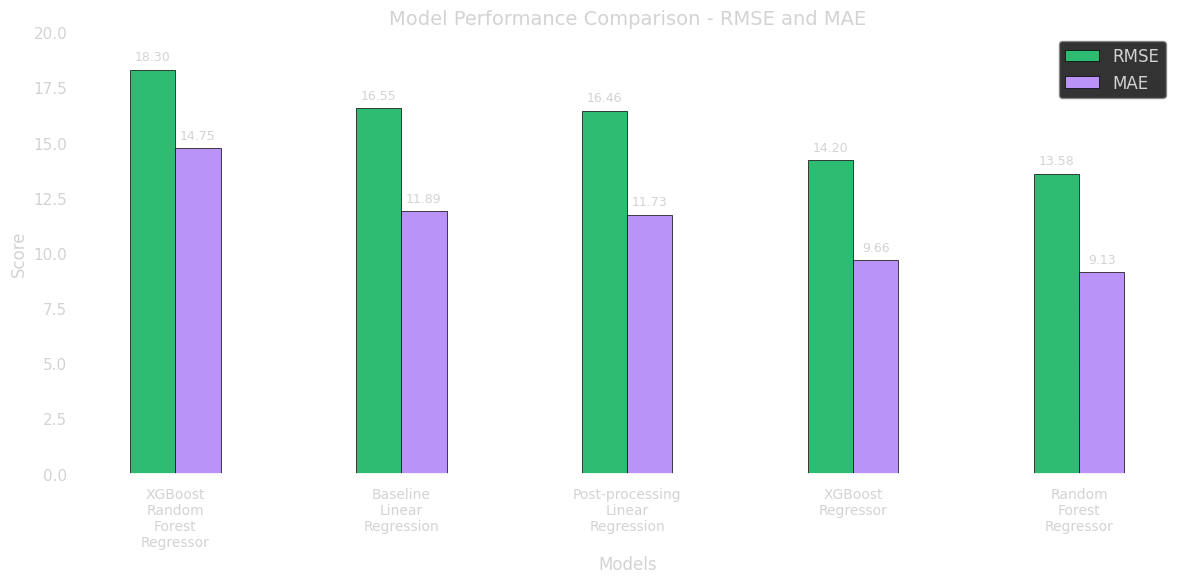

In [18]:
# Set figure size
plt.figure(figsize=(12, 6))

plt_df = full_results[full_results["Dataset"] == "Test"].sort_values("MSE", ascending=False)

# Create bar positions
x = range(len(plt_df))

# Create grouped bars for each metric with adjusted positions
bar_width = 0.2
bars1 = plt.bar(
    [i - bar_width / 2 for i in x],
    plt_df["RMSE"],
    bar_width,
    label="RMSE",
    color=spotify_colors[-1],
    edgecolor="black",
    linewidth=0.5,
)
bars2 = plt.bar(
    [i + bar_width / 2 for i in x],
    plt_df["MAE"],
    bar_width,
    label="MAE",
    color=spotify_colors[0],
    edgecolor="black",
    linewidth=0.5,
)

# Add value labels on top of each bar
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.3,
            f"{height:.2f}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

# Customize the plot
plt.xlabel("Models", color="lightgray", fontsize=12)
plt.ylabel("Score", color="lightgray", fontsize=12)
plt.title("Model Performance Comparison - RMSE and MAE", fontsize=14)

# Position x-ticks at the center of each model's bar group
# Format labels with newlines between words
labels = plt_df["Model"].str.replace(" ", "\n", regex=False)
plt.xticks(x, labels, rotation=0, ha="center", fontsize=10)

# Improve legend readability
plt.legend(loc="upper right", fontsize=12, frameon=True, facecolor="black", edgecolor="gray")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.grid(False, axis="x")  # Disable grid for x-axis
plt.ylim(0, 20)  # Set y-axis limit

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.savefig("images/rmse-mae.png", dpi=300, bbox_inches="tight", transparent=True)

plt.show()

#### Plot of MSE for each model

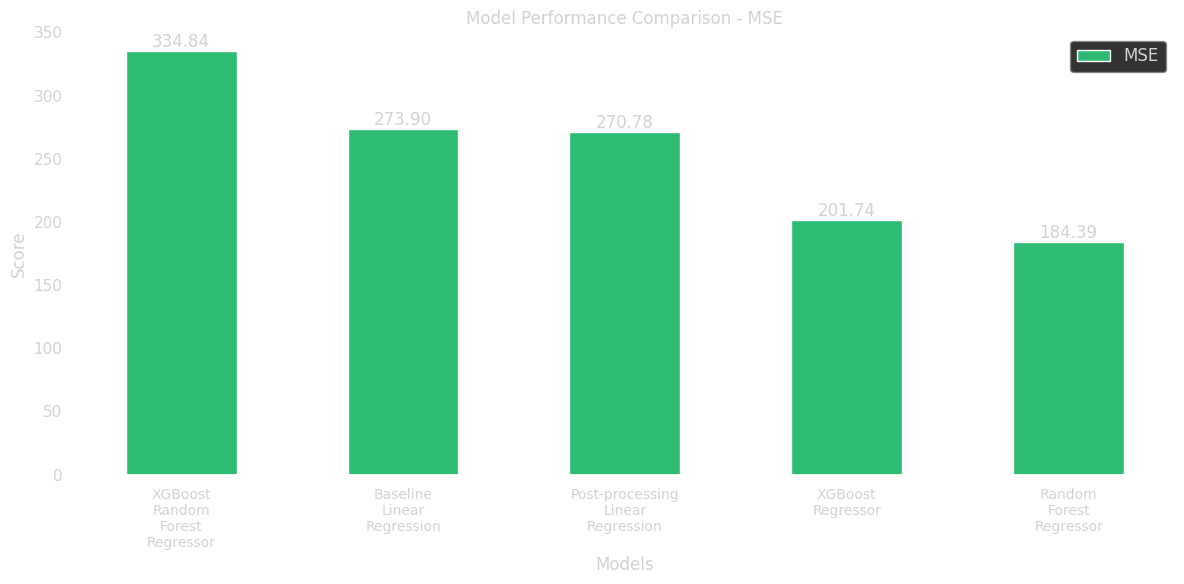

In [19]:
# Set figure size
plt.figure(figsize=(12, 6))

plt_df = full_results[full_results["Dataset"] == "Test"].sort_values("MSE", ascending=False)

# Create bar positions
x = range(len(plt_df))

# Create bar plot for MSE
bars = plt.bar(x, plt_df["MSE"], width=0.5, color=spotify_colors[-1], label="MSE")

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f"{height:.2f}", ha="center", va="bottom")

# Customize the plot
plt.xlabel("Models", color="lightgray", fontsize=12)
plt.ylabel("Score", color="lightgray", fontsize=12)
plt.title("Model Performance Comparison - MSE")

# Position x-ticks at the center of each model's bar group
# Format labels with newlines between words
labels = plt_df["Model"].str.replace(" ", "\n", regex=False)
plt.xticks(x, labels, rotation=0, ha="center", fontsize=10)

plt.legend(loc="upper right", fontsize=12, frameon=True, facecolor="black", edgecolor="gray")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.grid(False, axis="x")  # Disable grid for x-axis

plt.ylim(0, 350)  # Set y-axis limit to 10% above max value

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.savefig("images/mse.png", dpi=300, bbox_inches="tight", transparent=True)

plt.show()

#### Predictions vs Actual

Created and saved 5 individual model plots to images/ directory


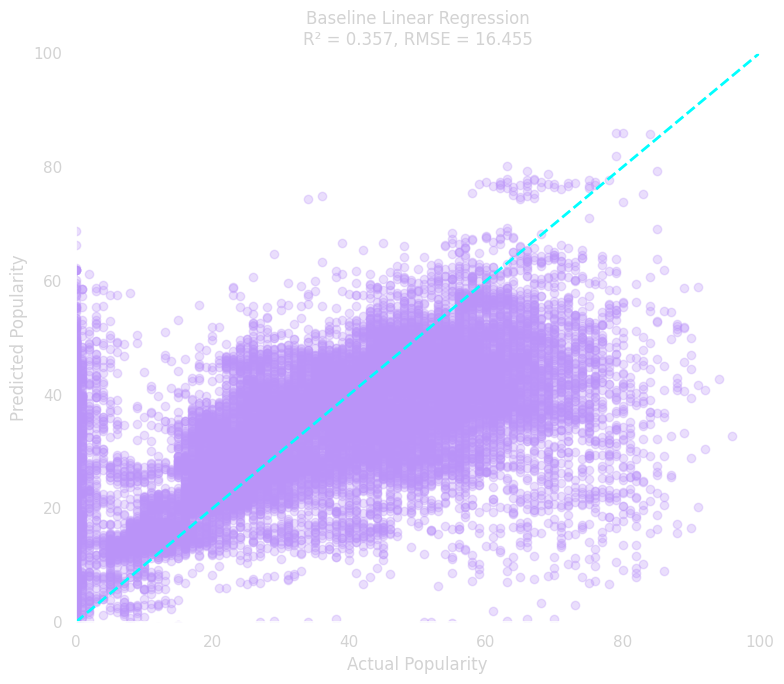

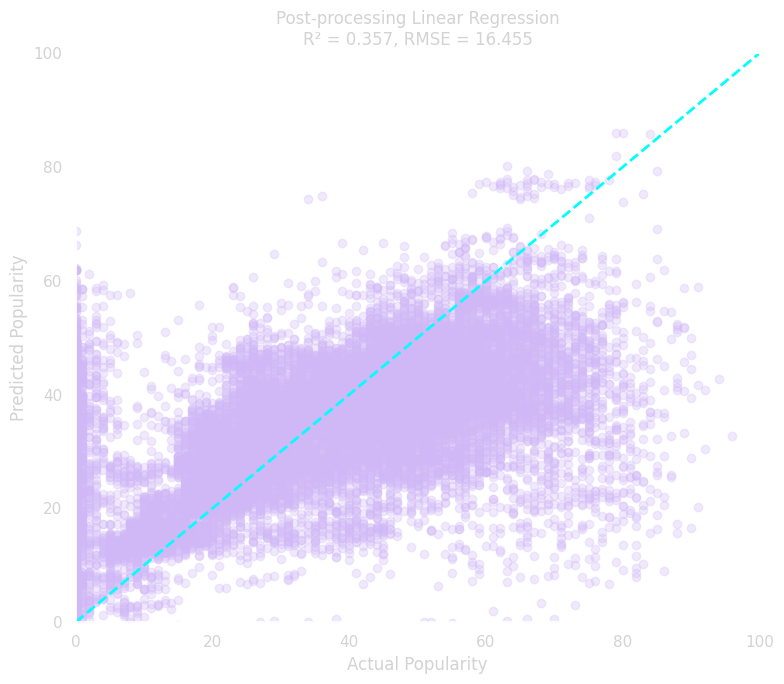

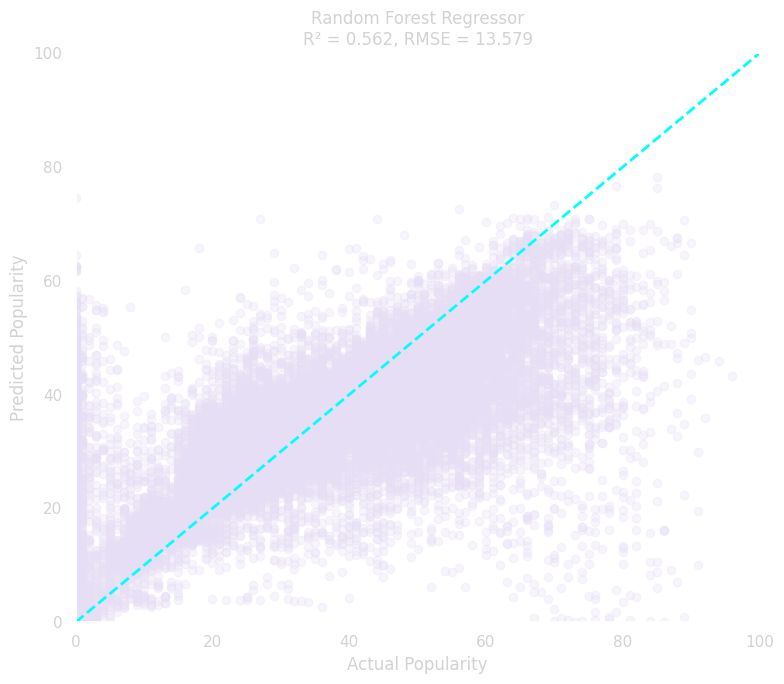

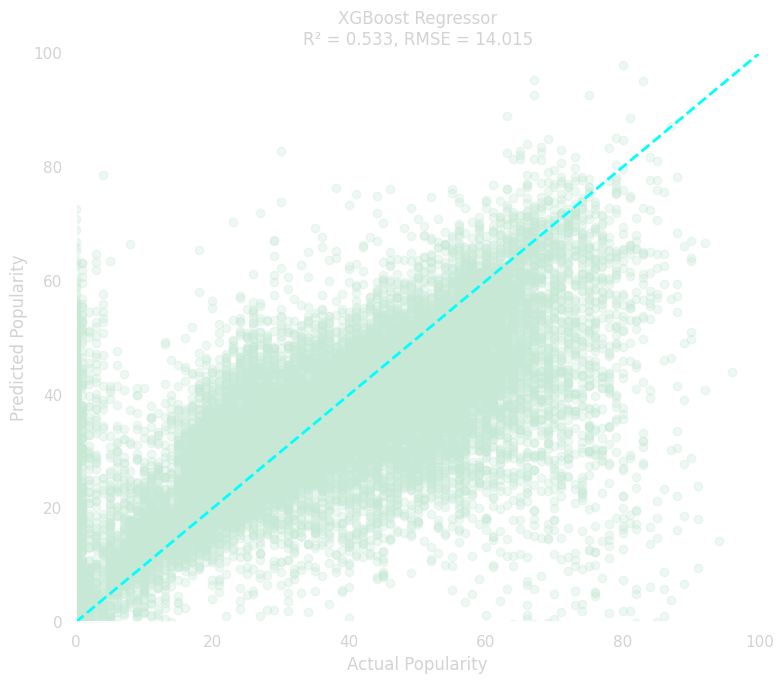

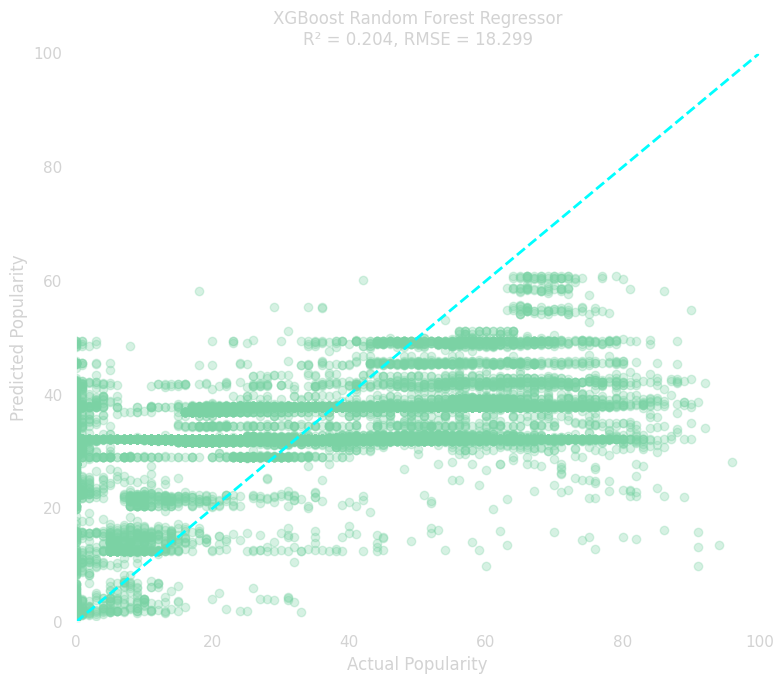

In [20]:
# Get unique models from the results
models = full_results[full_results["Dataset"] == "Test"]["Model"].unique()

# Prepare X and y data
X = df[df.columns.difference(["popularity"])]
y = df["popularity"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Dictionary to store model instances
model_instances = {
    "Baseline Linear Regression": LinearRegression(n_jobs=-1),
    "Post-processing Linear Regression": LinearRegression(n_jobs=-1),
    "Random Forest Regressor": RandomForestRegressor(
        n_estimators=200, random_state=42, n_jobs=-1, max_features="sqrt"
    ),
    "XGBoost Regressor": XGBRegressor(
        tree_method="hist", n_estimators=300, n_jobs=-1, random_state=42, enable_categorical=True
    ),
    "XGBoost Random Forest Regressor": XGBRFRegressor(
        tree_method="hist", n_estimators=200, n_jobs=-1, random_state=42, enable_categorical=True
    ),
}

# Create separate figures for each model
for i, model_name in enumerate(models):
    # Create a new figure for each model
    plt.figure(figsize=(8, 7))

    # Train the model
    model = model_instances[model_name]
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Create scatter plot of actual vs predicted values
    plt.scatter(y_test, y_pred, alpha=0.3, color=spotify_colors[i % len(spotify_colors)])

    # Add perfect prediction line
    min_val = 0
    max_val = 100
    plt.plot([min_val, max_val], [min_val, max_val], "--", lw=2, color="cyan")

    # Calculate metrics for the title
    r2 = r2_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)

    # Set title and labels
    plt.title(f"{model_name}\nR² = {r2:.3f}, RMSE = {rmse:.3f}", fontsize=12, color="lightgray")
    plt.xlabel("Actual Popularity", color="lightgray")
    plt.ylabel("Predicted Popularity", color="lightgray")

    # Set tick colors
    plt.tick_params(colors="lightgray")

    # Add grid
    plt.grid(True, linestyle="--", alpha=0.7)

    # Set equal limits for better comparison
    plt.xlim(0, 100)
    plt.ylim(0, 100)

    # Adjust layout
    plt.tight_layout()

    # Save the figure
    plt.savefig(
        f"images/predicted_vs_actual_{model_name.replace(' ', '_').lower()}.png",
        dpi=300,
        bbox_inches="tight",
        transparent=True,
    )

# Show a message instead of displaying all plots at once
print(f"Created and saved {len(models)} individual model plots to images/ directory")

In [22]:
full_results.to_csv("data/model_results.csv", index=False)
full_results

,Model,Dataset,R²,MSE,RMSE,MAE
0,Baseline Linear Regression,Test,0.349180,273.897624,16.549853,11.890188
1,Baseline Linear Regression,Train,0.355471,273.743524,16.545196,11.893864
0,Post-processing Linear Regression,Test,0.356594,270.777689,16.455324,11.727340
1,Post-processing Linear Regression,Train,0.365137,269.637920,16.420655,11.704718
0,Random Forest Regressor,Test,0.561858,184.392086,13.579105,9.126881
1,Random Forest Regressor,Train,0.926086,31.392637,5.602913,3.553841
0,XGBoost Regressor,Test,0.519100,201.743164,14.203632,9.662746
1,XGBoost Regressor,Train,0.666832,141.588531,11.899098,8.235728
0,XGBoost Random Forest Regressor,Test,0.204361,334.844971,18.298769,14.747857
1,XGBoost Random Forest Regressor,Train,0.205610,337.392120,18.368237,14.788769


## KFold Cross Validation

Because the Random Forest Regressor performed the best, we will use it for KFold Cross Validation.

In [ ]:
# Assuming 'df' is already loaded and preprocessed
target = "popularity"
features = df.columns.difference(["popularity"])


# Preprocessing function (No scaling needed for Random Forest)
def preprocess_data(df, features, target):
    X = df[features]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    return X_train, X_test, y_train, y_test


# Nested Cross-Validation function with GridSearchCV
def nested_cv(model, param_grid, X, y, k_outer=5, k_inner=3):
    outer_kf = KFold(n_splits=k_outer, shuffle=True, random_state=42)
    outer_mses = []

    # Store all parameter combinations and their corresponding MSE for visualization
    param_combinations = []
    mse_values = []

    # Outer loop for cross-validation with tqdm progress bar
    for train_index, test_index in tqdm(outer_kf.split(X), total=k_outer, desc="Outer loop"):
        X_train_outer, X_test_outer = X.iloc[train_index], X.iloc[test_index]
        y_train_outer, y_test_outer = y.iloc[train_index], y.iloc[test_index]

        # Inner loop for hyperparameter tuning using GridSearchCV
        inner_kf = KFold(n_splits=k_inner, shuffle=True, random_state=42)
        grid_search = GridSearchCV(
            model, param_grid, cv=inner_kf, scoring="neg_mean_squared_error", verbose=3
        )
        grid_search.fit(X_train_outer, y_train_outer)

        # Store the grid search results
        param_combinations.extend(grid_search.cv_results_["params"])
        mse_values.extend(grid_search.cv_results_["mean_test_score"])

        # Get the best model
        best_model = grid_search.best_estimator_

        # Predictions on the outer fold's test set
        y_pred_outer = best_model.predict(X_test_outer)
        outer_mses.append(mean_squared_error(y_test_outer, y_pred_outer))

    return np.mean(outer_mses), param_combinations, mse_values


# Parameter grid for RandomForest
param_grid = {
    "n_estimators": [100, 200, 300],  # Number of trees
    "max_depth": [40, 50, 60],  # Depth of trees
    "min_samples_split": [2, 5, 10],  # Minimum samples to split
    "n_jobs": [-1],  # Use all processors
    "max_features": ["sqrt"],  # Number of features to consider for the best split
}

# Preprocess the data
X_train, X_test, y_train, y_test = preprocess_data(df, features, target)

# Perform Nested Cross-Validation for RandomForest
nested_mse, param_combinations, mse_values = nested_cv(
    RandomForestRegressor(), param_grid, X_train, y_train
)

# Output the best parameters and the nested cross-validation MSE
print(f"Nested CV Mean MSE: {nested_mse}")

# Convert the results into a DataFrame for easier plotting
results_df = pd.DataFrame(param_combinations)
results_df["mse"] = mse_values

In [ ]:
# # Plotting
# plt.figure(figsize=(12, 8))

# # Plot MSE vs. n_estimators
# plt.subplot(2, 2, 1)
# for max_depth in param_grid["max_depth"]:
#     for min_samples_split in param_grid["min_samples_split"]:
#         subset = results_df[
#             (results_df["max_depth"] == max_depth)
#             & (results_df["min_samples_split"] == min_samples_split)
#         ]
#         plt.plot(
#             subset["n_estimators"],
#             subset["mse"],
#             label=f"max_depth={max_depth}, min_samples_split={min_samples_split}",
#         )

# plt.title("MSE vs. Number of Estimators")
# plt.xlabel("Number of Estimators")
# plt.ylabel("Mean Squared Error")
# plt.legend()

# # Plot MSE vs. max_depth
# plt.subplot(2, 2, 2)
# for n_estimators in param_grid["n_estimators"]:
#     for min_samples_split in param_grid["min_samples_split"]:
#         subset = results_df[
#             (results_df["n_estimators"] == n_estimators)
#             & (results_df["min_samples_split"] == min_samples_split)
#         ]
#         plt.plot(
#             subset["max_depth"],
#             subset["mse"],
#             label=f"n_estimators={n_estimators}, min_samples_split={min_samples_split}",
#         )

# plt.title("MSE vs. Max Depth")
# plt.xlabel("Max Depth")
# plt.ylabel("Mean Squared Error")
# plt.legend()

# # Plot MSE vs. min_samples_split
# plt.subplot(2, 2, 3)
# for n_estimators in param_grid["n_estimators"]:
#     for max_depth in param_grid["max_depth"]:
#         subset = results_df[
#             (results_df["n_estimators"] == n_estimators) & (results_df["max_depth"] == max_depth)
#         ]
#         plt.plot(
#             subset["min_samples_split"],
#             subset["mse"],
#             label=f"n_estimators={n_estimators}, max_depth={max_depth}",
#         )

# plt.title("MSE vs. Min Samples Split")
# plt.xlabel("Min Samples Split")
# plt.ylabel("Mean Squared Error")
# plt.legend()

# plt.tight_layout()
# plt.show()

In [ ]:
# # Plotting
# plt.figure(figsize=(12, 8))

# results_grouped = results_df.groupby(["n_estimators", "max_depth", "min_samples_split"])["mse"].agg("mean").reset_index()

# # Plot MSE vs. n_estimators
# plt.subplot(3, 1, 1)
# for max_depth in param_grid['max_depth']:
#     for min_samples_split in param_grid['min_samples_split']:
#         subset = results_grouped[
#             (results_grouped['max_depth'] == max_depth) &
#             (results_grouped['min_samples_split'] == min_samples_split)
#         ]
#         plt.scatter(subset['n_estimators'], subset['mse'], label=f"max_depth={max_depth}, min_samples_split={min_samples_split}")

# plt.title("MSE vs. Number of Estimators")
# plt.xlabel("Number of Estimators")
# plt.ylabel("Mean Squared Error")
# plt.legend()

# # Plot MSE vs. max_depth
# plt.subplot(3, 1, 2)
# for n_estimators in param_grid['n_estimators']:
#     for min_samples_split in param_grid['min_samples_split']:
#         subset = results_grouped[
#             (results_grouped['n_estimators'] == n_estimators) &
#             (results_grouped['min_samples_split'] == min_samples_split)
#         ]
#         plt.plot(subset['max_depth'], subset['mse'], label=f"n_estimators={n_estimators}, min_samples_split={min_samples_split}")

# plt.title("MSE vs. Max Depth")
# plt.xlabel("Max Depth")
# plt.ylabel("Mean Squared Error")
# plt.legend()

# # Plot MSE vs. min_samples_split
# plt.subplot(3, 1, 3)
# for n_estimators in param_grid['n_estimators']:
#     for max_depth in param_grid['max_depth']:
#         subset = results_grouped[
#             (results_grouped['n_estimators'] == n_estimators) &
#             (results_grouped['max_depth'] == max_depth)
#         ]
#         plt.plot(subset['min_samples_split'], subset['mse'], label=f"n_estimators={n_estimators}, max_depth={max_depth}")

# plt.title("MSE vs. Min Samples Split")
# plt.xlabel("Min Samples Split")
# plt.ylabel("Mean Squared Error")
# plt.tight_layout()
# plt.legend()
# plt.show()
